# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics 
* Run Resnet inference on test images
* Export saved Resnet weights for future inference



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


# Install fastai dependencies

In [30]:
!pip install fastai

In [31]:
from fastai.vision import *

# Download Custom Classification Data From Roboflow

In [4]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="folder", notebook="roboflow-resnet")

     |████████████████████████████████| 145 kB 5.3 MB/s 
     |████████████████████████████████| 178 kB 41.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 138 kB 46.6 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=folder&ref=roboflow-resnet


In [32]:
#dataset imported from Roboflow. You can sign up at roboflow.com and upload your image classification dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="a5aWTUiYHQVfauyhKClV")
project = rf.workspace().project("image-based-biometry-assignment-part-3")
dataset = project.version(4).download("folder")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Image-based-biometry-assignment-part-3-4 in folder:: 100%|██████████| 2371/2371 [00:01<00:00, 1207.11it/s]


In [33]:
dataset.location

'/content/Image-based-biometry-assignment-part-3-4'

In [34]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path(dataset.location)
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
97, 99, 92, 98, 90...
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
#double check the data classes
data.classes

['1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9']

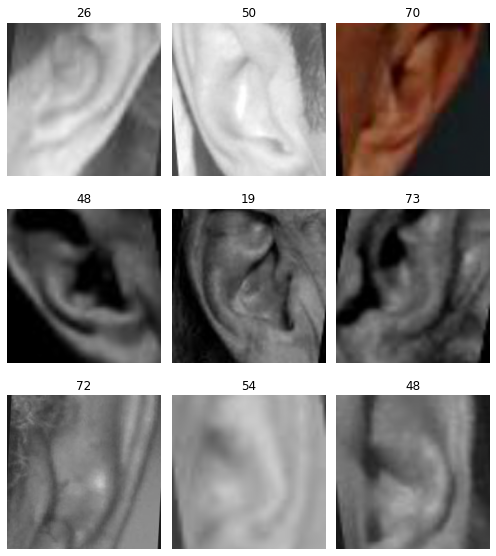

In [36]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [37]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [38]:
#print network layers
learn

Learner(data=ImageDataBunch;

Train: LabelList (1685 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,44,44,44
Path: /content/Image-based-biometry-assignment-part-3-4;

Valid: LabelList (214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,75,75,73
Path: /content/Image-based-biometry-assignment-part-3-4;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, e

# Train Custom Resnet Image Classifier

In [39]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [40]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,5.874379,5.389366,0.981308,00:15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

Better model found at epoch 0 with valid_loss value: 5.3893656730651855.


In [41]:
#load best model from frozen training
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (1685 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,44,44,44
Path: /content/Image-based-biometry-assignment-part-3-4;

Valid: LabelList (214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,75,75,73
Path: /content/Image-based-biometry-assignment-part-3-4;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, e

In [42]:
learn.unfreeze()

In [43]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [44]:
optimal_lr = find_appropriate_lr(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [45]:
learn.fit_one_cycle(1, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,4.270464,5.267714,0.985981,00:20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

Better model found at epoch 0 with valid_loss value: 5.26771354675293.


In [46]:
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (1685 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,44,44,44
Path: /content/Image-based-biometry-assignment-part-3-4;

Valid: LabelList (214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
44,44,75,75,73
Path: /content/Image-based-biometry-assignment-part-3-4;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, e

# Evaluate Classifier Performance

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


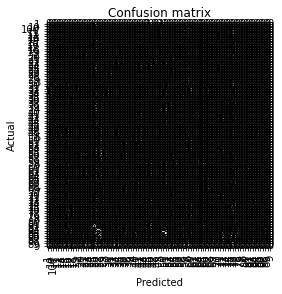

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


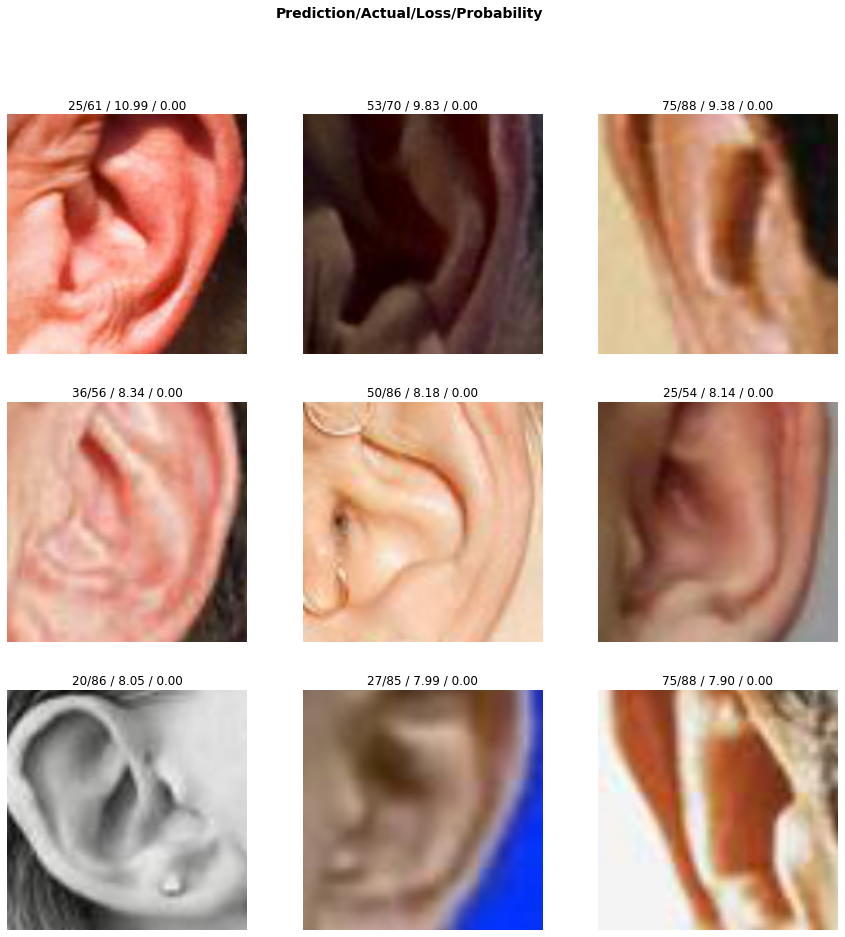

In [48]:
interp.plot_top_losses(9, figsize=(15,15))


/content/Image-based-biometry-assignment-part-3-4/test/44/0092_png.rf.9f689d21c154113c069a5a52daa8e28e.jpg
57


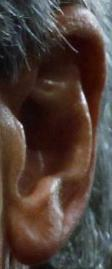



/content/Image-based-biometry-assignment-part-3-4/test/46/0098_png.rf.972f8c02ad4f1de0965ccb9ce3c8b8f6.jpg
36


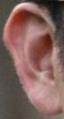



/content/Image-based-biometry-assignment-part-3-4/test/46/0097_png.rf.13253b9c90f596d95c06cd5f50455db0.jpg
75


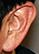



/content/Image-based-biometry-assignment-part-3-4/test/46/0099_png.rf.5ac186928e9052944eb313dc77146897.jpg
75


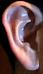



/content/Image-based-biometry-assignment-part-3-4/test/14/0012_png.rf.3f8adb129a4e79cd99ace7bf8a159481.jpg
64


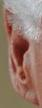



/content/Image-based-biometry-assignment-part-3-4/test/14/0011_png.rf.b0e0b34c7fd10b3d4ccadd4f14a56480.jpg
81


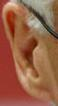



/content/Image-based-biometry-assignment-part-3-4/test/11/0001_png.rf.bacf8d193a0a5db27301e673fd95d8ae.jpg
75


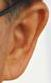



/content/Image-based-biometry-assignment-part-3-4/test/11/0002_png.rf.24654902a023cad2afdb159a3a52400b.jpg
59


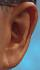



/content/Image-based-biometry-assignment-part-3-4/test/11/0003_png.rf.daaf8a2f342f4f5a2e08f48cd43c1e18.jpg
75


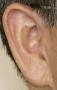



/content/Image-based-biometry-assignment-part-3-4/test/2/0009_png.rf.35c998a6a20376fb9b2e98591e40f4ae.jpg
53


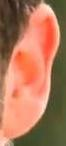



/content/Image-based-biometry-assignment-part-3-4/test/2/0007_png.rf.b4ea5debd9702c86c1963dba17dfb167.jpg
36


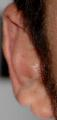



/content/Image-based-biometry-assignment-part-3-4/test/96/0238_png.rf.25a0377a20d4fe9a73633e7fa5e10250.jpg
25


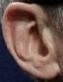



/content/Image-based-biometry-assignment-part-3-4/test/96/0236_png.rf.f2963e2b2a73fb703564970373c628e8.jpg
34


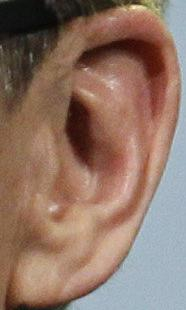



/content/Image-based-biometry-assignment-part-3-4/test/96/0235_png.rf.090199553fb5ff450eb0c278385bd9f2.jpg
50


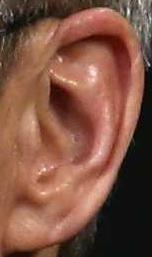



/content/Image-based-biometry-assignment-part-3-4/test/96/0250_png.rf.f1bc573823f806100b928c9a05b97118.jpg
45


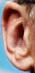



/content/Image-based-biometry-assignment-part-3-4/test/13/0010_png.rf.1959bd35384fadb91ed350589fc19700.jpg
25


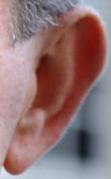



/content/Image-based-biometry-assignment-part-3-4/test/82/0601_png.rf.f758ac9c01227b4854a357c3880a4a23.jpg
82


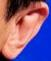



/content/Image-based-biometry-assignment-part-3-4/test/41/0085_png.rf.3557f398c96ceee7a2d25cb3fb86a452.jpg
40


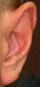



/content/Image-based-biometry-assignment-part-3-4/test/41/0086_png.rf.de6c2d40a7890b3aaf42532ecb81c0ce.jpg
6


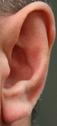



/content/Image-based-biometry-assignment-part-3-4/test/41/0087_png.rf.cc49da99a11c53bb63fc3a58cfba3935.jpg
82


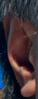



/content/Image-based-biometry-assignment-part-3-4/test/3/0037_png.rf.dcf0c9ee8b8b2ee32295ef46ab43360b.jpg
40


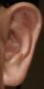



/content/Image-based-biometry-assignment-part-3-4/test/3/0040_png.rf.9bb24ecd1fd1800a6f67e7d4623bbc64.jpg
25


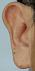



/content/Image-based-biometry-assignment-part-3-4/test/3/0042_png.rf.6e9f5bf6f86886d7b156ab0a641f3ed6.jpg
33


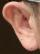



/content/Image-based-biometry-assignment-part-3-4/test/25/0043_png.rf.454a7cfd033a9c4729414985209f057c.jpg
25


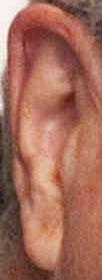



/content/Image-based-biometry-assignment-part-3-4/test/43/0091_png.rf.8c95b453e2e03038be31d69d645fa402.jpg
82




/content/Image-based-biometry-assignment-part-3-4/test/29/0052_png.rf.c6688c5bc642808ee7f80309bb079072.jpg
51


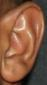



/content/Image-based-biometry-assignment-part-3-4/test/29/0053_png.rf.d87b66d3aee467263e6b3392920b97fa.jpg
59


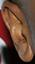



/content/Image-based-biometry-assignment-part-3-4/test/29/0054_png.rf.659c61fda8251306e0801f18c83106dd.jpg
25


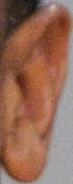



/content/Image-based-biometry-assignment-part-3-4/test/15/0013_png.rf.60303b1ba392b10c69f6ab2450c94c4b.jpg
75


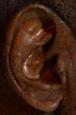



/content/Image-based-biometry-assignment-part-3-4/test/15/0015_png.rf.07460119c6bddcbbb280c9b16cee98c3.jpg
45


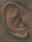



/content/Image-based-biometry-assignment-part-3-4/test/15/0014_png.rf.c6d8b7bd2038d38a5a9cb8784c43b71f.jpg
82


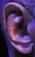



/content/Image-based-biometry-assignment-part-3-4/test/23/0035_png.rf.d32ccda1064b65f80b5404cecc5d8cd1.jpg
75


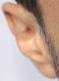



/content/Image-based-biometry-assignment-part-3-4/test/23/0034_png.rf.d2876e689ccca7353b1d5a38428caf4b.jpg
87


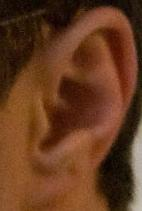



/content/Image-based-biometry-assignment-part-3-4/test/23/0036_png.rf.56844c515a879482e5c4656c0e12b23b.jpg
50


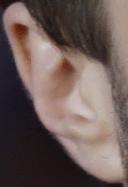



/content/Image-based-biometry-assignment-part-3-4/test/26/0045_png.rf.20300bd1586ee665ef30e5cdb8e1ab81.jpg
50


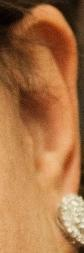



/content/Image-based-biometry-assignment-part-3-4/test/26/0044_png.rf.18e45f654810b2bec7bd38a06fdd947b.jpg
12


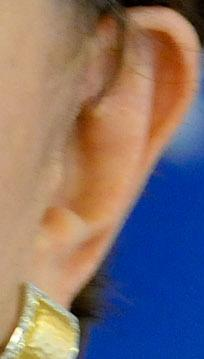



/content/Image-based-biometry-assignment-part-3-4/test/20/0026_png.rf.77056dde15ec56f1d4d00b614681b6d0.jpg
82


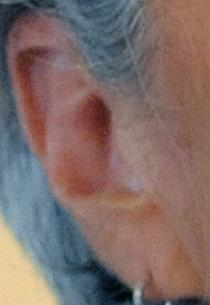



/content/Image-based-biometry-assignment-part-3-4/test/20/0027_png.rf.ddb4d58e63853ddfb77fd65e274bcd5c.jpg
6


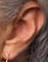



/content/Image-based-biometry-assignment-part-3-4/test/98/0242_png.rf.ab122074ccef7c6e5711c25557803ca5.jpg
10


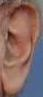



/content/Image-based-biometry-assignment-part-3-4/test/98/0241_png.rf.e1f564e40ab427f3e214e365cf3b59be.jpg
4


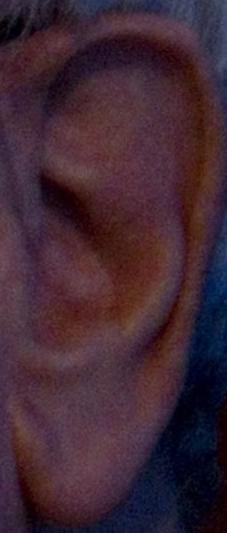



/content/Image-based-biometry-assignment-part-3-4/test/91/0222_png.rf.c7e2facb50f29a785cd19dcaf52edece.jpg
50


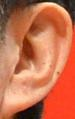



/content/Image-based-biometry-assignment-part-3-4/test/5/0103_png.rf.73adfa37a3ce9c39702130a26672fe10.jpg
45




/content/Image-based-biometry-assignment-part-3-4/test/5/0106_png.rf.c21cdc01bd690a00ff6d7ebba61bf325.jpg
8




/content/Image-based-biometry-assignment-part-3-4/test/5/0108_png.rf.919596ddfd1812b8dbb69884acd68e36.jpg
27




/content/Image-based-biometry-assignment-part-3-4/test/37/0076_png.rf.35c2b3a6cda588d32a28a2e095b2e068.jpg
45


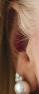



/content/Image-based-biometry-assignment-part-3-4/test/34/0064_png.rf.bdd1143e973c51c8e054b26955c75469.jpg
76


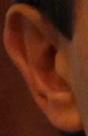



/content/Image-based-biometry-assignment-part-3-4/test/34/0065_png.rf.a93c85699e8965acc1b53a139a09f2de.jpg
50


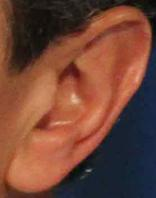



/content/Image-based-biometry-assignment-part-3-4/test/34/0066_png.rf.c30163d93a2af92715e9405ec93432a8.jpg
50


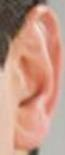



/content/Image-based-biometry-assignment-part-3-4/test/90/0221_png.rf.495b5b6dfc27a2073dcbc6a6c442ef6d.jpg
1


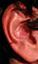



/content/Image-based-biometry-assignment-part-3-4/test/90/0220_png.rf.a836a8647c9cd99bdc129f58ff7f6c00.jpg
50


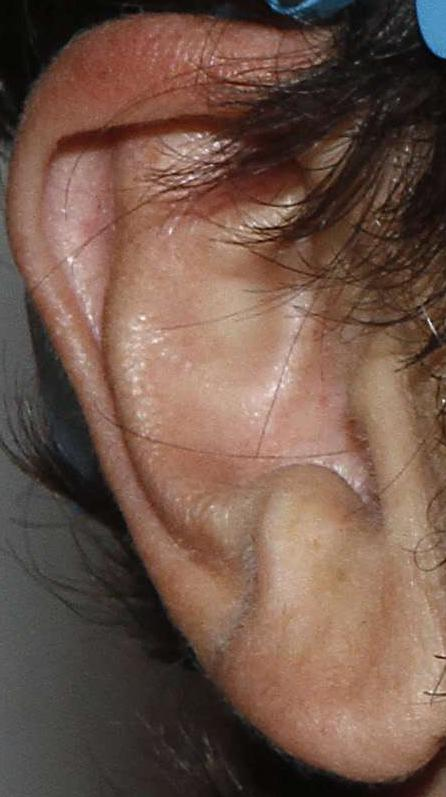



/content/Image-based-biometry-assignment-part-3-4/test/90/0219_png.rf.5bc5b6e604b244859269fea792998510.jpg
57




/content/Image-based-biometry-assignment-part-3-4/test/52/0115_png.rf.d114613bb810bbfba662ad869528247a.jpg
25


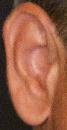



/content/Image-based-biometry-assignment-part-3-4/test/52/0117_png.rf.cee28706703ecd8c25c1a551b6081cef.jpg
25


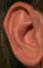



/content/Image-based-biometry-assignment-part-3-4/test/52/0116_png.rf.6cd3d383999188b8cfc50f0765ee7a8f.jpg
76


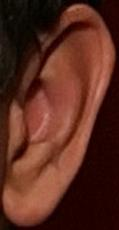



/content/Image-based-biometry-assignment-part-3-4/test/32/0060_png.rf.b8e573b832b2ce0cb5110c35ad4be5c3.jpg
50


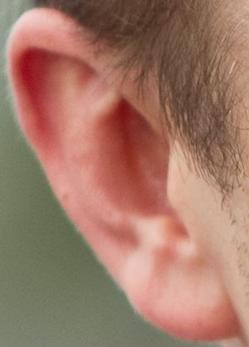



/content/Image-based-biometry-assignment-part-3-4/test/32/0059_png.rf.87936858056c9965326bfdf19f7cb580.jpg
33


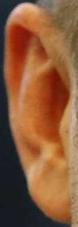



/content/Image-based-biometry-assignment-part-3-4/test/94/0228_png.rf.f2e5f546ecea8af0d161c6ec0bc4d04e.jpg
72


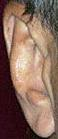



/content/Image-based-biometry-assignment-part-3-4/test/94/0229_png.rf.dce4921b4f0adda5e97326f57918dabe.jpg
15


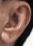



/content/Image-based-biometry-assignment-part-3-4/test/94/0230_png.rf.54c0231687f82c336d698fc3974e0c4a.jpg
57




/content/Image-based-biometry-assignment-part-3-4/test/38/0078_png.rf.7724c152958994fe2e4438e8cac309a8.jpg
17


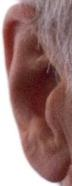



/content/Image-based-biometry-assignment-part-3-4/test/38/0077_png.rf.896eda36142fbfaba1c91506f19f2964.jpg
40


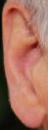



/content/Image-based-biometry-assignment-part-3-4/test/49/0109_png.rf.975a890bd0773798b2920845946ed655.jpg
57


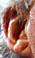



/content/Image-based-biometry-assignment-part-3-4/test/28/0051_png.rf.c84eff342219e67aa233c47610aab12a.jpg
50


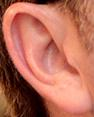



/content/Image-based-biometry-assignment-part-3-4/test/28/0049_png.rf.a519f02e1fe302db80baed7ab2fe2042.jpg
82




/content/Image-based-biometry-assignment-part-3-4/test/28/0050_png.rf.7a546aba66c6c486aa7444a584cbf025.jpg
61




/content/Image-based-biometry-assignment-part-3-4/test/27/0046_png.rf.a3ca655771a7b8895039eb04410a82ef.jpg
62


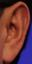



/content/Image-based-biometry-assignment-part-3-4/test/27/0048_png.rf.4a7ff59953ea85921e1c36d8a69cee16.jpg
61


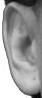



/content/Image-based-biometry-assignment-part-3-4/test/27/0047_png.rf.c63a0ae8be3ca4d4aeca7a1aa34b1197.jpg
45


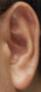



/content/Image-based-biometry-assignment-part-3-4/test/19/0025_png.rf.3aeefaa2751d0a5f4644c658f3e2f59f.jpg
33


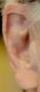



/content/Image-based-biometry-assignment-part-3-4/test/31/0058_png.rf.396890ea9a7dc0e71d7794378ce20103.jpg
3


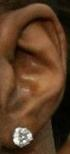



/content/Image-based-biometry-assignment-part-3-4/test/10/0239_png.rf.adccbd6c977746a25ca3bcda3dcd3a32.jpg
57


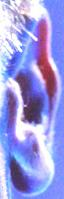



/content/Image-based-biometry-assignment-part-3-4/test/10/0234_png.rf.121cb31fb4eba3c2a22475a0f1816804.jpg
25


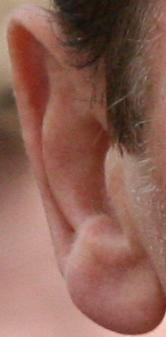



/content/Image-based-biometry-assignment-part-3-4/test/10/0237_png.rf.598daee597ee49eae3fc80cc590d9451.jpg
11


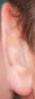



/content/Image-based-biometry-assignment-part-3-4/test/33/0061_png.rf.8155c874ebc9045a537341c672d560e8.jpg
75


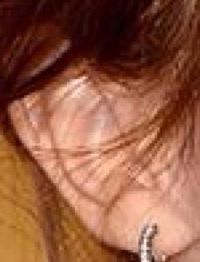



/content/Image-based-biometry-assignment-part-3-4/test/33/0063_png.rf.4c9cc890e2c0ba68ac7a7add43f0c726.jpg
33


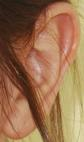



/content/Image-based-biometry-assignment-part-3-4/test/33/0062_png.rf.5d41a19286ed603568dbd4beccf9deeb.jpg
76


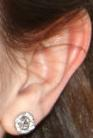



/content/Image-based-biometry-assignment-part-3-4/test/18/0022_png.rf.e6eb9f4d69886d4c0a73d651ff5f21ab.jpg
70


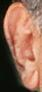



/content/Image-based-biometry-assignment-part-3-4/test/18/0023_png.rf.abda1dfef76c5a58ffba2ec9cfdb617b.jpg
6


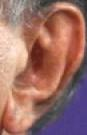



/content/Image-based-biometry-assignment-part-3-4/test/18/0024_png.rf.79e43f3fc6091a30c4d50e8f467d8de5.jpg
71


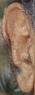



/content/Image-based-biometry-assignment-part-3-4/test/21/0029_png.rf.0e2753e2a313e942c6d8c8e6ed0489e1.jpg
76


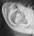



/content/Image-based-biometry-assignment-part-3-4/test/21/0028_png.rf.ff0a9e5a605a61b69735187425c3fa0a.jpg
71


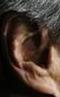



/content/Image-based-biometry-assignment-part-3-4/test/21/0030_png.rf.9e4e9c1ded99387274ef815431058cee.jpg
76


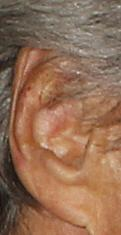



/content/Image-based-biometry-assignment-part-3-4/test/12/0005_png.rf.15120709b9b512a0a6cdfbf88e5e43c3.jpg
15


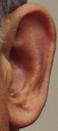



/content/Image-based-biometry-assignment-part-3-4/test/12/0006_png.rf.b61d3b61b35fca6fc0ed498c66e60cfe.jpg
6


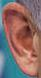



/content/Image-based-biometry-assignment-part-3-4/test/12/0008_png.rf.3e9a3e80aed8bb5419b59c9535f4cd5b.jpg
25


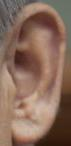



/content/Image-based-biometry-assignment-part-3-4/test/95/0233_png.rf.dd846ba056d1457f7171640f3fbc4345.jpg
6


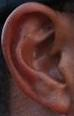



/content/Image-based-biometry-assignment-part-3-4/test/95/0231_png.rf.ea197d40ad86a3c1d8269a756b93d23a.jpg
33


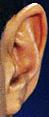



/content/Image-based-biometry-assignment-part-3-4/test/95/0232_png.rf.80d2d745357d3fc37850741ffa194e1c.jpg
53


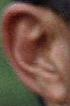



/content/Image-based-biometry-assignment-part-3-4/test/36/0071_png.rf.53c9cf0cc54b3e6ba26c0eb7f49a8234.jpg
75


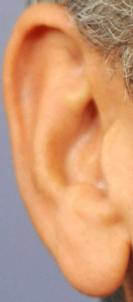



/content/Image-based-biometry-assignment-part-3-4/test/36/0072_png.rf.8030086d193278f42b133da9018f0314.jpg
75


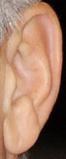



/content/Image-based-biometry-assignment-part-3-4/test/36/0074_png.rf.f7b583a360bd6a9e5c1b3636f924cd5a.jpg
25


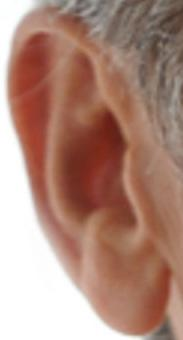



/content/Image-based-biometry-assignment-part-3-4/test/16/0016_png.rf.d8265215bf187789c26cb1b3a8362b2f.jpg
50


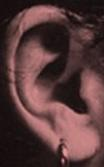



/content/Image-based-biometry-assignment-part-3-4/test/16/0017_png.rf.ca7cde09e6a095d3dcc2b2dd80373004.jpg
4


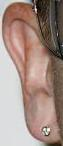



/content/Image-based-biometry-assignment-part-3-4/test/16/0018_png.rf.552d5e4d90d28da1204a3ba15b54c3af.jpg
12


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


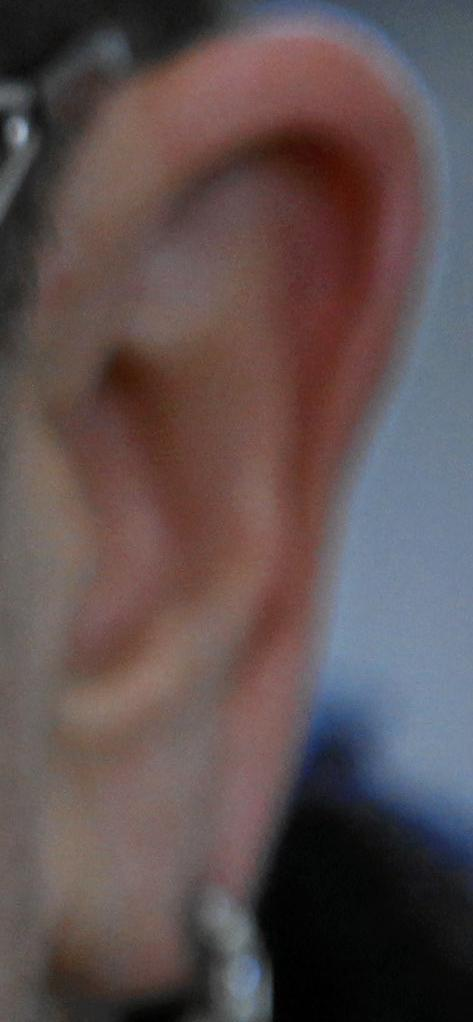



/content/Image-based-biometry-assignment-part-3-4/test/97/0240_png.rf.e9e2348ce3645f36b920b859d6bd067d.jpg
25


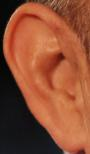



/content/Image-based-biometry-assignment-part-3-4/test/45/0096_png.rf.46abb2eff6ce6fa11ad705ec27b98ded.jpg
60




/content/Image-based-biometry-assignment-part-3-4/test/45/0094_png.rf.e365ea36deca6cc64809773bff6a77f2.jpg
62


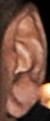



/content/Image-based-biometry-assignment-part-3-4/test/45/0095_png.rf.cf5516fdfe90215af07c6882288cb602.jpg
59




/content/Image-based-biometry-assignment-part-3-4/test/30/0056_png.rf.590ab925e082803a7a2ec6b194de7af6.jpg
28


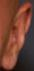



/content/Image-based-biometry-assignment-part-3-4/test/30/0057_png.rf.b147a49326bb5ba3dd475a9763de7117.jpg
25


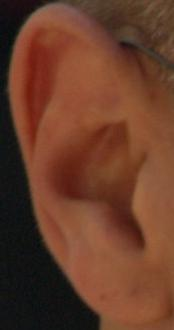



/content/Image-based-biometry-assignment-part-3-4/test/30/0055_png.rf.859b7f2ccef1a6922a62af33e01cb33f.jpg
25


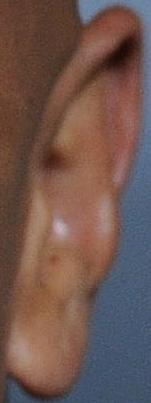



/content/Image-based-biometry-assignment-part-3-4/test/4/0070_png.rf.725c5f0ef50e04f02b4a367591295d35.jpg
76


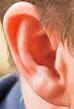



/content/Image-based-biometry-assignment-part-3-4/test/4/0073_png.rf.798185852d64623b6868b3bd1ebe6dc9.jpg
50


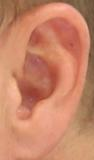



/content/Image-based-biometry-assignment-part-3-4/test/4/0075_png.rf.78067f0171579321386591892ada5090.jpg
76


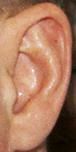



/content/Image-based-biometry-assignment-part-3-4/test/51/0112_png.rf.b3c5aa4f6163c1252dabc9099eaf103d.jpg
45


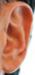



/content/Image-based-biometry-assignment-part-3-4/test/51/0113_png.rf.d5b7137eb655fc39c7e701082d8a4e38.jpg
62




/content/Image-based-biometry-assignment-part-3-4/test/51/0114_png.rf.2552be013272a317c515fbc143898a10.jpg
6


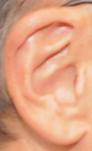



/content/Image-based-biometry-assignment-part-3-4/test/99/0244_png.rf.47cf2f93d09249c16d3e5be8e75c9045.jpg
75


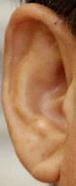



/content/Image-based-biometry-assignment-part-3-4/test/99/0245_png.rf.1e936ea90ce2822c7df7d6a3f2811b25.jpg
5


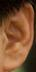



/content/Image-based-biometry-assignment-part-3-4/test/99/0243_png.rf.840e1104a351a07cb18d7cad5c8473d9.jpg
6


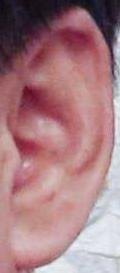



/content/Image-based-biometry-assignment-part-3-4/test/92/0224_png.rf.603ece4dea0f30492237c181caa74506.jpg
53


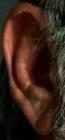



/content/Image-based-biometry-assignment-part-3-4/test/92/0223_png.rf.8c36a65089e2e6953be792cf660a1268.jpg
3


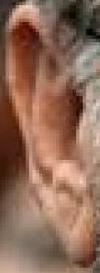



/content/Image-based-biometry-assignment-part-3-4/test/93/0227_png.rf.10669b99c01aa51b081bb76c9d3c4229.jpg
70


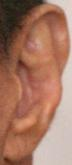



/content/Image-based-biometry-assignment-part-3-4/test/93/0226_png.rf.b1a2ddf96dc09f2f3d1c9f990db730e3.jpg
70


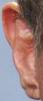



/content/Image-based-biometry-assignment-part-3-4/test/93/0249_png.rf.dfd5b462061dae43e57b3cd43c53669f.jpg
6


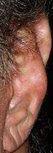



/content/Image-based-biometry-assignment-part-3-4/test/93/0225_png.rf.005b207bd55d8c1e1cbbf6f7c4730d6d.jpg
33


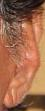



/content/Image-based-biometry-assignment-part-3-4/test/22/0033_png.rf.e299ab3ccea40453adda99d1b36dca69.jpg
27




/content/Image-based-biometry-assignment-part-3-4/test/22/0031_png.rf.418d0a733c635fc120f2779d74a0b2b2.jpg
59




/content/Image-based-biometry-assignment-part-3-4/test/22/0032_png.rf.09e37b8122aa0844604441fb69740538.jpg
15




/content/Image-based-biometry-assignment-part-3-4/test/39/0081_png.rf.d626e97598f15fa353544eaa7a875d53.jpg
14


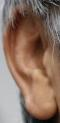



/content/Image-based-biometry-assignment-part-3-4/test/39/0079_png.rf.2cdf857b1c9ac57aaaf76603c7e65b30.jpg
89


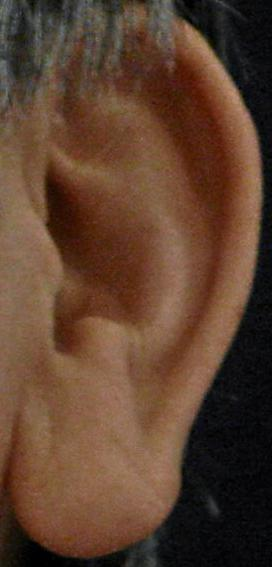



/content/Image-based-biometry-assignment-part-3-4/test/39/0080_png.rf.922395a5296326c4f66f29f30292c2f8.jpg
25


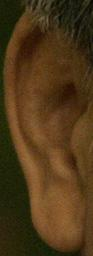



/content/Image-based-biometry-assignment-part-3-4/test/48/0105_png.rf.ae1dcdbe6256e51e1ba123348d23aca2.jpg
15


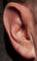



/content/Image-based-biometry-assignment-part-3-4/test/48/0107_png.rf.8f80be9051e1a0a92e487ba43bb99474.jpg
57


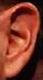



/content/Image-based-biometry-assignment-part-3-4/test/48/0104_png.rf.0bb21d99797db884337442130658b1b1.jpg
57




/content/Image-based-biometry-assignment-part-3-4/test/100/0247_png.rf.1aa3b8010a7600f9316ad78ce61d0999.jpg
45


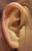



/content/Image-based-biometry-assignment-part-3-4/test/100/0246_png.rf.18138040b9583a0854af1217c9f05491.jpg
64


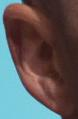



/content/Image-based-biometry-assignment-part-3-4/test/100/0248_png.rf.c9f489add52001ef79f601e27c863155.jpg
57


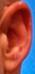



/content/Image-based-biometry-assignment-part-3-4/test/17/0019_png.rf.9c860bb7ff758f683ee969950a9f2594.jpg
59


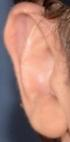



/content/Image-based-biometry-assignment-part-3-4/test/17/0021_png.rf.542cfc223d507091ef183920634e33dd.jpg
25


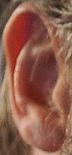



/content/Image-based-biometry-assignment-part-3-4/test/17/0020_png.rf.da63c688b8bc883d97622cfdb95268a1.jpg
25


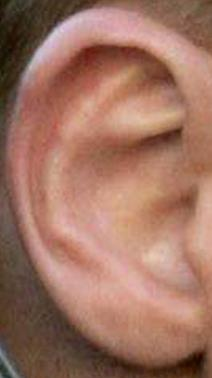



/content/Image-based-biometry-assignment-part-3-4/test/35/0069_png.rf.a27017b015e7d773782c8099daa5921d.jpg
86


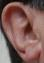



/content/Image-based-biometry-assignment-part-3-4/test/35/0068_png.rf.997bbc5d2a406b96d29f2cebabba30bf.jpg
14




/content/Image-based-biometry-assignment-part-3-4/test/35/0067_png.rf.fca7c0ef24f045060785c18f3686ef74.jpg
53


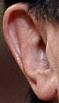



/content/Image-based-biometry-assignment-part-3-4/test/24/0041_png.rf.4abeb28050ff70614db9653dd3ad0487.jpg
6


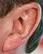



/content/Image-based-biometry-assignment-part-3-4/test/24/0039_png.rf.e93c84f8be74b4df65a78c1d79318959.jpg
25


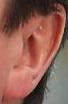



/content/Image-based-biometry-assignment-part-3-4/test/24/0038_png.rf.b6c959423536b589cb17d7f9aa5c7082.jpg
50


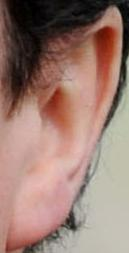



/content/Image-based-biometry-assignment-part-3-4/test/42/0088_png.rf.0533f3a1760854c4fbae2937b5383dd3.jpg
75


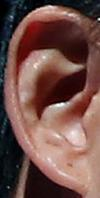



/content/Image-based-biometry-assignment-part-3-4/test/42/0090_png.rf.1ae74b6b3ca0715b5cc5e38ffdf71517.jpg
86


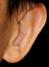



/content/Image-based-biometry-assignment-part-3-4/test/42/0089_png.rf.49869f1fbd04335d9721b4c00da43382.jpg
75


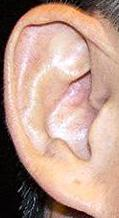



/content/Image-based-biometry-assignment-part-3-4/test/1/0004_png.rf.ba827ae0d84b785964bb71aca78c690f.jpg
76


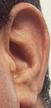



/content/Image-based-biometry-assignment-part-3-4/test/50/0110_png.rf.b6dd9a5ac77fcc5ceb372925f00892fc.jpg
81


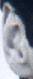



/content/Image-based-biometry-assignment-part-3-4/test/50/0111_png.rf.4565df2b9ceaef6706205c2bd5abcd25.jpg
50


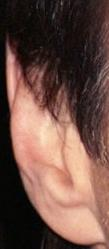



/content/Image-based-biometry-assignment-part-3-4/test/47/0100_png.rf.3e4c8544925de40ac8fa9b546026e5c3.jpg
76


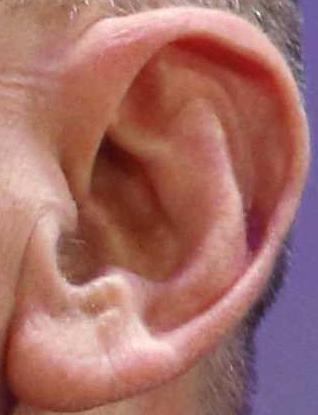



/content/Image-based-biometry-assignment-part-3-4/test/47/0101_png.rf.1f0d5cc21e72bce9dc3521c99f5bd6a3.jpg
33


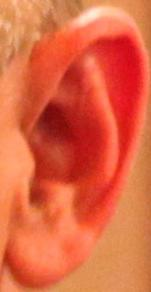



/content/Image-based-biometry-assignment-part-3-4/test/47/0102_png.rf.1a7e65eca69b25c5fcf055c98d15c04d.jpg
36


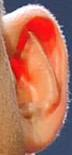



/content/Image-based-biometry-assignment-part-3-4/test/40/0083_png.rf.b7552a6f2fd0d0e11f28136fbaac6607.jpg
62


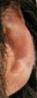



/content/Image-based-biometry-assignment-part-3-4/test/40/0082_png.rf.046d3cb0c76859f50598ebba7fd19526.jpg
9


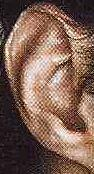



/content/Image-based-biometry-assignment-part-3-4/test/40/0084_png.rf.f7a62ab3050bf7e6a79b2bfd14d40aaa.jpg
33


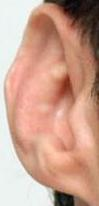

In [49]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/Image-based-biometry-assignment-part-3-4/test/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

Compute rank-1 accuracy

In [50]:
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()

def compute_rank_n(n):

  classifications = 0
  rank = 0

  for imageName in glob.glob('/content/Image-based-biometry-assignment-part-3-4/test/*/*.jpg'):
    real_class = str(os.path.basename(os.path.dirname(imageName)))

    img = open_image(imageName)
    prediction = learn.predict(img)
    _, i = prediction[2].topk(n)
 
    classes = data.classes
    for x in i:
      predicted_class = str(classes[x.item()])
      if real_class == predicted_class:
        rank = rank + 1
        break

    classifications = classifications + 1
  result = rank/classifications

  print("Rank " + str(n) + " = " + str(result))
  return result

  

In [51]:
compute_rank_n(1)
compute_rank_n(5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Rank 1 = 0.026845637583892617


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Rank 5 = 0.087248322147651


0.087248322147651

# Save custom classification model for future use

In [55]:
#model is automatically saved with the "save_best_model" callback
%ls Image-based-biometry-assignment-part-3-4/models/

best_resnet34.pth  tmp.pth


In [56]:
from google.colab import files
files.download('./Image-based-biometry-assignment-part-3-4/models/best_resnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>